<a href="https://colab.research.google.com/github/yuvalpn/Electra_Financial_Data/blob/main/Clean_Electra_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install pdfplumber

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 107.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 97.5 MB/s eta 0:00:00


🕵️ Starting PDF Extraction...
⚠️ Warning: File Q1_2025.pdf not found. Skipping.
⚠️ Warning: File Q2_2025.pdf not found. Skipping.
⚠️ Warning: File Q3_2025.pdf not found. Skipping.
🔄 Generating Historical Estimates (2022-2024)...
⚠️ No 2025 data extracted. Using placeholder data for demo.
🔌 Loading data to SQL (electra.db)...
📊 Verifying data via SQL Query:
   Year  Total_Revenue
0  2022           6180
1  2023           6488
2  2024           7406
3  2025           5574
📈 Dashboard generated.


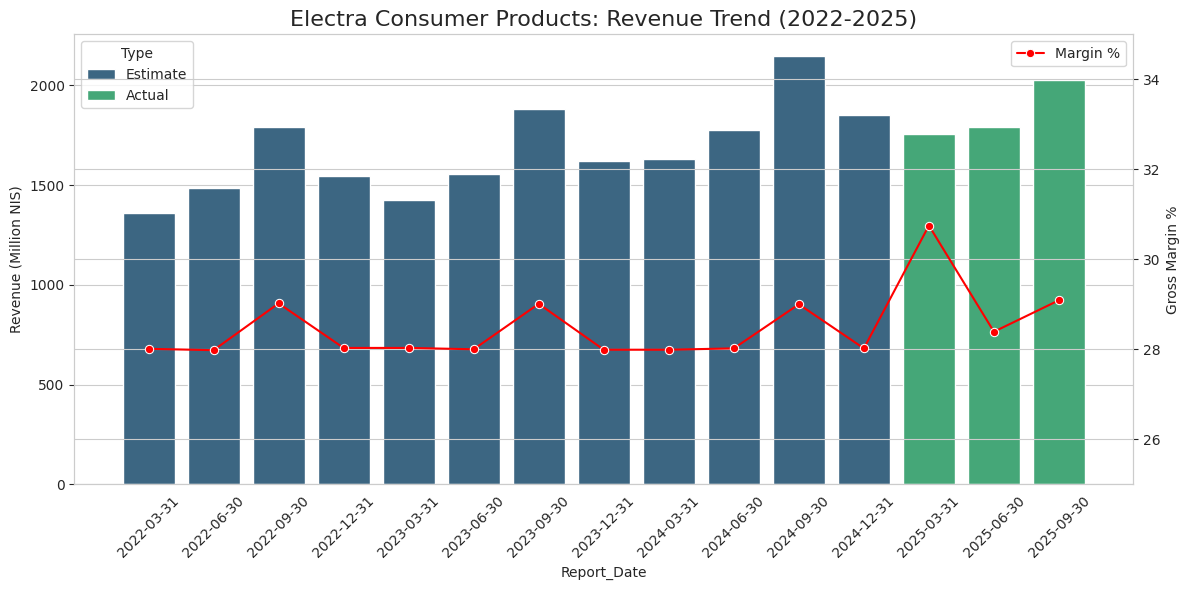

In [4]:
"""
Electra Consumer Products - Financial Data Pipeline (ETL)
-------------------------------------------------------
Author: [Your Name]
Description:
    This script performs an End-to-End ETL process:
    1. Extracts financial data from raw PDF reports (handling RTL/Visual Hebrew).
    2. Transforms and cleans the data (merging with historical estimates).
    3. Loads the data into a SQLite database.
    4. Analyzes and visualizes Revenue & Margin trends.
"""

import pdfplumber
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os

# =============================================================================
# 1. CONFIGURATION
# =============================================================================

# נתיב לתיקייה (יש לשנות בהתאם לסביבת הריצה)
DATA_FOLDER = '/content/drive/MyDrive/my_data/Electra_Financial_Data'

# הגדרת קבצי 2025 והעמודים הרלוונטיים (דוח רווח והפסד)
FILES_2025_CONFIG = {
    'Q1_2025.pdf': {'page': 30, 'quarter': 'Q1'},
    'Q2_2025.pdf': {'page': 35, 'quarter': 'Q2'},
    'Q3_2025.pdf': {'page': 37, 'quarter': 'Q3'}
}

# מילות מפתח בעברית הפוכה (Visual Hebrew) לזיהוי שורות בטבלה
# דוגמה: "הכנסות" -> "תוסנכה" ב-PDF
KEYWORDS_MAP = {
    'Revenue': ['תוסנכה', 'תוריכמ', 'מכירות'],       # הכנסות / מכירות
    'Gross_Profit': ['י מלוג חוור', 'גולמי'],          # רווח גולמי
}

# נתונים שנתיים היסטוריים (מתוך דוחות שנתיים) + מודל עונתיות להשלמה
HISTORICAL_ANNUAL_TOTALS = {
    2022: 6180,
    2023: 6488,
    2024: 7406
}

# התפלגות עונתיות משוערת (Q3 חזק בגלל הקיץ)
SEASONALITY_PROFILE = {'Q1': 0.22, 'Q2': 0.24, 'Q3': 0.29, 'Q4': 0.25}

# =============================================================================
# 2. EXTRACTION LOGIC (The Hard Part)
# =============================================================================

def clean_and_parse_line(line):
    """Cleans a text line and extracts all numbers using Regex."""
    # הסרת תווים מפריעים: פסיקים, והחלפת סוגריים במינוס
    clean_line = line.replace(',', '').replace('(', '-').replace(')', '')
    # חילוץ מספרים (כולל עשרוניים ושליליים)
    numbers = [float(s) for s in re.findall(r'-?\d+\.?\d*', clean_line)]
    return numbers

def extract_pdf_data(folder, files_config):
    """
    Iterates over PDF files, locates the specific table page,
    and extracts Revenue/Gross Profit using keyword matching.
    """
    extracted_data = []

    print("🕵️ Starting PDF Extraction...")

    for filename, config in files_config.items():
        path = os.path.join(folder, filename)
        quarter = config['quarter']
        page_num = config['page']

        # טיפול במקרה שהקובץ לא קיים (כדי שהקוד ירוץ גם בגיטהאב כדוגמה)
        if not os.path.exists(path):
            print(f"⚠️ Warning: File {filename} not found. Skipping.")
            continue

        print(f"   📄 Processing {filename} (Page {page_num})...")

        try:
            with pdfplumber.open(path) as pdf:
                page = pdf.pages[page_num - 1] # 0-based index
                text = page.extract_text()

                row_data = {'Year': 2025, 'Quarter': quarter, 'Type': 'Actual'}

                for line in text.split('\n'):
                    # בדיקת הכנסות
                    if any(k in line for k in KEYWORDS_MAP['Revenue']):
                        nums = clean_and_parse_line(line)
                        # לוגיקה: המספר השלישי (אינדקס 2) הוא הרבעון הנוכחי
                        if len(nums) >= 3 and abs(nums[2]) > 100:
                            row_data['Revenue'] = nums[2]

                    # בדיקת רווח גולמי
                    if any(k in line for k in KEYWORDS_MAP['Gross_Profit']):
                        nums = clean_and_parse_line(line)
                        if len(nums) >= 3 and abs(nums[2]) > 100:
                            row_data['Gross_Profit'] = nums[2]

                # שמירה רק אם חולצו נתונים
                if 'Revenue' in row_data:
                    extracted_data.append(row_data)
                    print(f"      ✅ Extracted: Rev={row_data.get('Revenue')}, GP={row_data.get('Gross_Profit')}")

        except Exception as e:
            print(f"❌ Error processing {filename}: {e}")

    return extracted_data

# =============================================================================
# 3. DATA TRANSFORMATION & MODELING
# =============================================================================

def generate_historical_estimates():
    """Generates 2022-2024 quarterly data based on annual totals."""
    history = []
    print("🔄 Generating Historical Estimates (2022-2024)...")

    for year, total in HISTORICAL_ANNUAL_TOTALS.items():
        for q, pct in SEASONALITY_PROFILE.items():
            rev = round(total * pct)
            # הנחת רווחיות: 28% בממוצע, 29% ב-Q3
            margin = 0.29 if q == 'Q3' else 0.28
            gp = round(rev * margin)

            history.append({
                'Year': year,
                'Quarter': q,
                'Revenue': rev,
                'Gross_Profit': gp,
                'Type': 'Estimate'
            })
    return history

def build_master_dataset(extracted_2025):
    """Merges historical estimates with extracted actuals."""
    history = generate_historical_estimates()

    # אם החילוץ נכשל (למשל אין קבצים), נשתמש בנתוני דמה ל-2025 לצורך הדגמה
    if not extracted_2025:
        print("⚠️ No 2025 data extracted. Using placeholder data for demo.")
        extracted_2025 = [
            {'Year': 2025, 'Quarter': 'Q1', 'Revenue': 1756, 'Gross_Profit': 540, 'Type': 'Actual'},
            {'Year': 2025, 'Quarter': 'Q2', 'Revenue': 1793, 'Gross_Profit': 509, 'Type': 'Actual'},
            {'Year': 2025, 'Quarter': 'Q3', 'Revenue': 2025, 'Gross_Profit': 589, 'Type': 'Actual'}
        ]

    full_data = history + extracted_2025
    df = pd.DataFrame(full_data)

    # חישובים נוספים
    quarter_dates = {'Q1': '03-31', 'Q2': '06-30', 'Q3': '09-30', 'Q4': '12-31'}
    df['Report_Date'] = df.apply(lambda row: f"{row['Year']}-{quarter_dates[row['Quarter']]}", axis=1)
    df['Gross_Margin_Pct'] = (df['Gross_Profit'] / df['Revenue'] * 100).round(2)

    return df.sort_values('Report_Date')

# =============================================================================
# 4. SQL LOADING
# =============================================================================

def load_to_sqlite(df, db_name='electra.db'):
    """Loads the DataFrame into a SQLite database."""
    print(f"🔌 Loading data to SQL ({db_name})...")
    conn = sqlite3.connect(db_name)
    df.to_sql('Financial_Report', conn, if_exists='replace', index=False)

    # וריפיקציה: הדפסת שאילתה מהדאטה-בייס
    print("📊 Verifying data via SQL Query:")
    query = "SELECT Year, SUM(Revenue) as Total_Revenue FROM Financial_Report GROUP BY Year"
    print(pd.read_sql(query, conn))

    return conn

# =============================================================================
# 5. VISUALIZATION
# =============================================================================

def plot_dashboard(conn):
    """Fetches data from SQL and plots the dashboard."""
    df = pd.read_sql("SELECT * FROM Financial_Report", conn)

    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid")

    # Bar Plot (Revenue)
    ax = sns.barplot(data=df, x='Report_Date', y='Revenue', hue='Type', palette='viridis')
    ax.set_title('Electra Consumer Products: Revenue Trend (2022-2025)', fontsize=16)
    ax.set_ylabel('Revenue (Million NIS)')
    plt.xticks(rotation=45)

    # Line Plot (Margin) on secondary axis
    ax2 = ax.twinx()
    sns.lineplot(data=df, x='Report_Date', y='Gross_Margin_Pct', color='red', marker='o', ax=ax2, label='Margin %')
    ax2.set_ylabel('Gross Margin %')
    ax2.set_ylim(25, 35)

    print("📈 Dashboard generated.")
    plt.tight_layout()
    plt.show()

# =============================================================================
# MAIN EXECUTION
# =============================================================================

if __name__ == "__main__":
    # 1. Extract
    extracted_data = extract_pdf_data(DATA_FOLDER, FILES_2025_CONFIG)

    # 2. Transform
    master_df = build_master_dataset(extracted_data)

    # 3. Load
    db_connection = load_to_sqlite(master_df)

    # 4. Visualize
    plot_dashboard(db_connection)

    db_connection.close()